In [13]:
%matplotlib inline

import zipfile
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [14]:
with zipfile.ZipFile("data/fashion-mnist.zip") as z:
    with z.open("fashion-mnist_train.csv") as f:
        train_df = pd.read_csv(f)

    with z.open("fashion-mnist_test.csv") as f:
        test_df = pd.read_csv(f)

train = train_df.drop('label', axis='columns').to_numpy() / 255.0
test = test_df.drop('label', axis='columns').to_numpy() / 255.0

In [15]:
def print_images(images, title):
    fig, axs = plt.subplots(ncols=5, figsize=(13,4))
    
    for i, image in enumerate(images):
        axs[i].imshow(image, cmap='gray', vmin=0, vmax=255)
        axs[i].xaxis.set_visible(False)
        axs[i].yaxis.set_visible(False)

    fig.tight_layout()
    fig.suptitle(title, fontsize=15)
    plt.show()

In [55]:
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Lambda, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.models import Model, model_from_json
from keras import backend as K
from keras import objectives

In [150]:
def sampling(args):
    z_mean, z_variance = args
    epsilon = K.random_normal(shape=(batch_size, dest_dim))
    
    return z_mean + K.exp(z_variance) * epsilon

def get_intermediate_dims(initial_dim, dest_dim):
    intermediate_dim_1 = 16
    intermediate_dim_2 = 8
    intermediate_dim_3 = 150
    
    return intermediate_dim_1, intermediate_dim_2, intermediate_dim_3

def create_architecture(batch_size,
                        initial_dim,
                        intermediate_dim_1,
                        intermediate_dim_2,
                        intermediate_dim_3,
                        dest_dim):
    input_layer = Input(batch_shape=(batch_size, initial_dim[0], initial_dim[1], 1))
    
    encoder_l1 = Conv2D(intermediate_dim_1, (3, 3), padding='same', activation='relu', data_format='channels_last')(input_layer)
    encoder_l2 = MaxPooling2D((2, 2), padding='same')(encoder_l1)
    encoder_l3 = Conv2D(intermediate_dim_2, (3, 3), padding='same', activation='relu', data_format='channels_last')(encoder_l2)
    encoder_l4 = MaxPooling2D((2, 2), padding='same')(encoder_l3)
    encoder_l5 = Reshape((7*7*8,))(encoder_l4)
    encoder_l6 = Dense(intermediate_dim_3, activation='relu')(encoder_l5)

    z_mean = Dense(dest_dim)(encoder_l6)
    z_variance = Dense(dest_dim)(encoder_l6)

    reduced = Lambda(sampling)([z_mean, z_variance])

    decoder_l1 = Dense(intermediate_dim_3, activation='relu')(reduced)
    decoder_l2 = Dense(7*7*8, activation='relu')(decoder_l1)
    decoder_l3 = Reshape((7, 7, 8))(decoder_l2)
    decoder_l4 = Conv2D(intermediate_dim_2, (3, 3), padding='same', activation='relu', data_format='channels_last')(decoder_l3)
    decoder_l5 = UpSampling2D((2,2))(decoder_l4)
    decoder_l6 = Conv2D(intermediate_dim_1, (3, 3), padding='same', activation='relu', data_format='channels_last')(decoder_l5)
    decoder_l7 = UpSampling2D((2,2))(decoder_l6)
    
    decoder_l8 = Conv2D(1, (3,3), activation='sigmoid', data_format='channels_last', padding='same')(decoder_l7)
    decoded = Reshape((initial_dim[0] * initial_dim[1],))(decoder_l8)
    
    return input_layer, reduced, decoded, z_mean, z_variance

def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_variance - K.square(z_mean) - K.exp(z_variance), axis=-1)
    return xent_loss + kl_loss

def prepare_models(input_layer, reduced, decoded):
    end_to_end = Model(input_layer, decoded)
    encoder = Model(input_layer, reduced)
    
    return end_to_end, encoder

In [151]:
def create_model(batch_size, initial_dim, dest_dim):
    intermediate_dim_1, intermediate_dim_2, intermediate_dim_3 = get_intermediate_dims(initial_dim, dest_dim)
    input_layer, reduced, decoded, z_mean, z_variance = create_architecture(batch_size,
                                                                            initial_dim,
                                                                            intermediate_dim_1,
                                                                            intermediate_dim_2,
                                                                            intermediate_dim_3,
                                                                            dest_dim
                                                                           )
    end_to_end, encoder = prepare_models(input_layer, reduced, decoded)
    return end_to_end, encoder, z_mean, z_variance

In [44]:
def load_model(model_name):
    with open(f'models/{model_name}.json') as file:
        loaded_json = file.read()
    return model_from_json(loaded_json)

def load_weights(model, model_name, dest_dim, epochs):
    model.load_weights(f'weights/{model_name}_e{epochs}_d{dest_dim}.h5')

def save_model(model, filename):
    model_json = model.to_json()
    with open(f'models/{filename}.json', 'w') as file:
        file.write(model_json)
    
def save_weights(model, filename):
    model.save_weights(f'weights/{filename}.h5')

In [58]:
batch_size = 10000
initial_dim = (28, 28)
dest_dim = 15

In [153]:
for i, layer in enumerate(end_to_end.layers):
    print(f'layer {i} ({layer.name}): input_shape = {layer.input_shape}, output_shape = {layer.output_shape}')

layer 0 (input_35): input_shape = (10000, 28, 28, 1), output_shape = (10000, 28, 28, 1)
layer 1 (conv2d_105): input_shape = (10000, 28, 28, 1), output_shape = (10000, 28, 28, 16)
layer 2 (max_pooling2d_56): input_shape = (10000, 28, 28, 16), output_shape = (10000, 14, 14, 16)
layer 3 (conv2d_106): input_shape = (10000, 14, 14, 16), output_shape = (10000, 14, 14, 8)
layer 4 (max_pooling2d_57): input_shape = (10000, 14, 14, 8), output_shape = (10000, 7, 7, 8)
layer 5 (reshape_56): input_shape = (10000, 7, 7, 8), output_shape = (10000, 392)
layer 6 (dense_127): input_shape = (10000, 392), output_shape = (10000, 150)
layer 7 (dense_128): input_shape = (10000, 150), output_shape = (10000, 15)
layer 8 (dense_129): input_shape = (10000, 150), output_shape = (10000, 15)
layer 9 (lambda_21): input_shape = [(10000, 15), (10000, 15)], output_shape = (10000, 15)
layer 10 (dense_130): input_shape = (10000, 15), output_shape = (10000, 150)
layer 11 (dense_131): input_shape = (10000, 150), output_sha

In [152]:
end_to_end, encoder, z_mean, z_variance = create_model(batch_size, initial_dim, dest_dim)

end_to_end.compile(optimizer='rmsprop', loss=vae_loss)

In [12]:
load_weights(end_to_end, 'end_to_end_2hl', dest_dim, 100)

In [162]:
epochs = 100

end_to_end.fit(train.reshape((len(train), 28, 28, 1)), train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(test.reshape(len(test), 28, 28, 1), test)
              )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 56s 930us/step - loss: 0.4460 - val_loss: 0.4467
Epoch 2/100
60000/60000 [==============================] - 56s 925us/step - loss: 0.4464 - val_loss: 0.4458
Epoch 3/100
60000/60000 [==============================] - 54s 898us/step - loss: 0.4467 - val_loss: 0.4454
Epoch 4/100
60000/60000 [==============================] - 54s 902us/step - loss: 0.4458 - val_loss: 0.4476
Epoch 5/100
60000/60000 [==============================] - 54s 897us/step - loss: 0.4468 - val_loss: 0.4453
Epoch 6/100
60000/60000 [==============================] - 53s 885us/step - loss: 0.4464 - val_loss: 0.4460
Epoch 7/100
60000/60000 [==============================] - 53s 884us/step - loss: 0.4459 - val_loss: 0.4464
Epoch 8/100
60000/60000 [==============================] - 54s 899us/step - loss: 0.4463 - val_loss: 0.4456
Epoch 9/100
60000/60000 [==============================] - 54s 892us/step - loss: 0.44

Epoch 76/100
60000/60000 [==============================] - 53s 882us/step - loss: 0.4441 - val_loss: 0.4436
Epoch 77/100
60000/60000 [==============================] - 52s 875us/step - loss: 0.4440 - val_loss: 0.4447
Epoch 78/100
60000/60000 [==============================] - 54s 906us/step - loss: 0.4443 - val_loss: 0.4427
Epoch 79/100
60000/60000 [==============================] - 53s 884us/step - loss: 0.4445 - val_loss: 0.4438
Epoch 80/100
60000/60000 [==============================] - 54s 900us/step - loss: 0.4436 - val_loss: 0.4435
Epoch 81/100
60000/60000 [==============================] - 53s 882us/step - loss: 0.4444 - val_loss: 0.4438
Epoch 82/100
60000/60000 [==============================] - 53s 880us/step - loss: 0.4440 - val_loss: 0.4427
Epoch 83/100
60000/60000 [==============================] - 53s 877us/step - loss: 0.4435 - val_loss: 0.4445
Epoch 84/100
60000/60000 [==============================] - 52s 873us/step - loss: 0.4448 - val_loss: 0.4419
Epoch 85/100
60000/

In [18]:
first_5_images = train_df.head().drop('label', axis='columns').to_numpy().reshape((5,28,28))

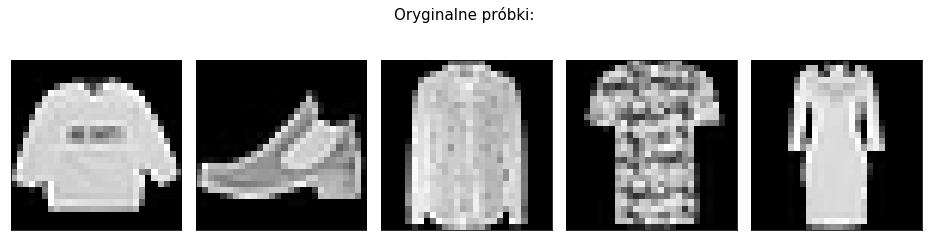

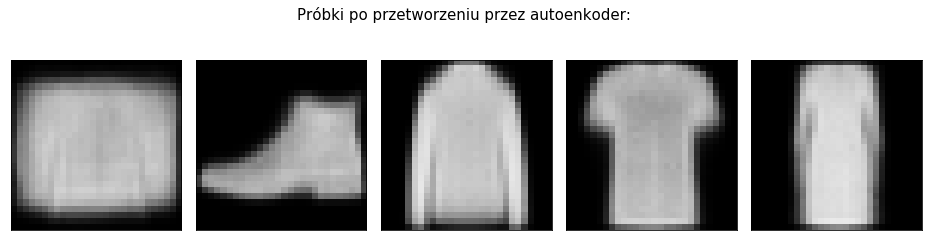

In [29]:
decoded = end_to_end.predict(train, batch_size=batch_size) * 256.0

print_images(first_5_images, 'Oryginalne próbki:')
print_images(decoded[:5].reshape((5,28,28)), 'Próbki po przetworzeniu przez autoenkoder:')

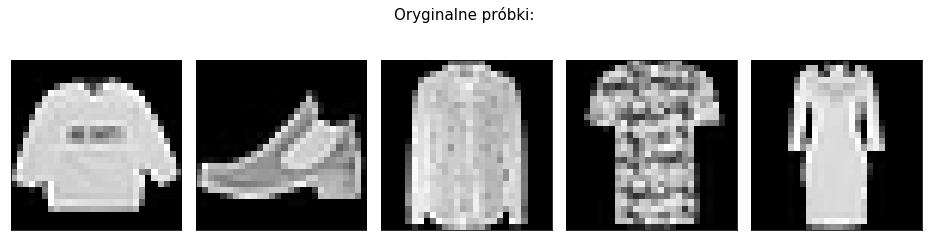

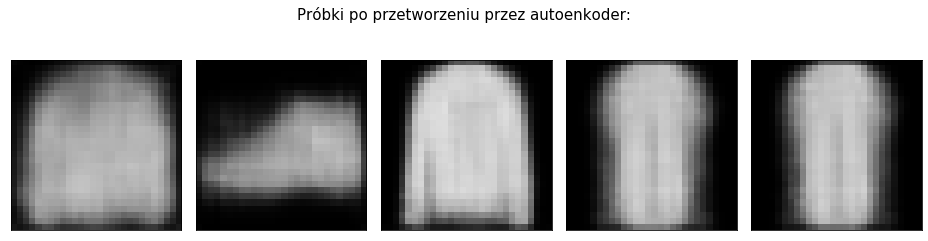

In [163]:
decoded = end_to_end.predict(train.reshape((len(train), 28, 28, 1)), batch_size=batch_size) * 256.0

print_images(first_5_images, 'Oryginalne próbki:')
print_images(decoded[:5].reshape((5,28,28)), 'Próbki po przetworzeniu przez autoenkoder:')

In [165]:
save_weights(end_to_end, 'end_to_end_cvae_e300_d15')

In [164]:
save_model(end_to_end, 'end_to_end_cvae_e300_d15')